In [23]:
# Code referenced from Martin Krasser's BNN implmentation https://github.com/krasserm
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer
from keras.layers import Input
from keras.models import Model
from keras import callbacks, optimizers
import warnings
import tqdm
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow_probability as tfp
%matplotlib inline

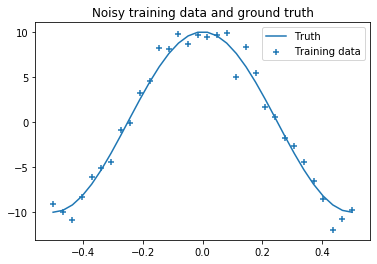

In [17]:
# Ground truth function
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.cos(2 * np.pi * (x)) + epsilon

# Generate random points for train data based on the function and a noise term
train_size = 32
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

In [145]:
def g(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return x + epsilon
g(np.array([1]),0.5)

array([0.14750529])

In [146]:
data = pd.DataFrame()
data['X'] = X
data['y'] = y

def noise(a):
    re

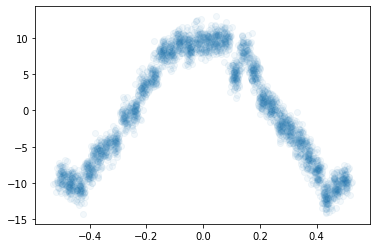

In [153]:
bs_samples_X = []
bs_samples_y = []

n_iters = 100

for i in range(n_iters):
    sampled = data.sample(frac=0.9, replace=True)
    
    bs_samples_X.append(g(sampled['X'], 0.01))
    bs_samples_y.append(g(sampled['y'], 1))
plt.scatter(bs_samples_X, bs_samples_y, alpha=0.05)

In [93]:
# x_test = np.linspace(0,1,2000)
# bs_samples

In [3]:
# Create Dense layer class by inheriting and overriding Keras Layers
class DenseVariational(Layer):
    
    # Definining the layers and the parameters here
    def __init__(self, units, kl_weight, activation=None, prior_sigma_1=1.5,
                 prior_sigma_2=0.1, prior_pi=0.5, **kwargs):
        
        self.units = units # Dimensionality of the output space
        self.kl_weight = kl_weight # 1 divided by the no. of batches; might remove if NF replaces KL
        self.activation = activations.get(activation) # Activation function
        self.prior_sigma_1 = prior_sigma_1 # Feeds into prior probability and init_sigma
        self.prior_sigma_2 = prior_sigma_2 # Feeds into prior probability and init_sigma
        self.prior_pi_1 = prior_pi # Feeds into prior probability and init_sigma
        self.prior_pi_2 = 1.0 - prior_pi # Feeds into prior probability and init_sigma
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2) 

        super().__init__(**kwargs)
    
    # Required for Keras; don't change this unless you just wanna rename variables
    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    # Required for Keras; allows for BNN functionality
    # Not sure if we need to update this seems to just be relating parameters to a NN
    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.init_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.init_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)

    # Required for Keras; this is the forward pass
    # Can specify custom losses thru self.add_loss(loss)
    # Probably need to update this to work with our NF implementation
    def call(self, inputs, **kwargs):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)

        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) +
                      self.kl_loss(bias, self.bias_mu, bias_sigma))

        return self.activation(K.dot(inputs, kernel) + bias)
    
    # This is how the loss is defined in this BNN implementation
    # Almost definitely will need to replace this
    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        return self.kl_weight * K.sum(variational_dist.log_prob(w) - self.log_prior_prob(w))
    
    # Used in their loss function
    # Likely that this will be replaced, but we need something similar for the Bayesian element
    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(w) +
                     self.prior_pi_2 * comp_2_dist.prob(w))

In [4]:
# BNN parameters
batch_size = train_size
num_batches = train_size / batch_size
kl_weight = 1.0 / num_batches

# Specify priors
prior_params = {
    'prior_sigma_1': 1.5, 
    'prior_sigma_2': 0.1, 
    'prior_pi': 0.5 
}

# Set up our BNN with input layer, 2 hidden layers, 1 output layer
x_in = Input(shape=(1,))
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x_in)
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariational(1, kl_weight, **prior_params)(x)
model = Model(x_in, x)

In [5]:
# Define a custom loss function
# We might have to do something similar based on how our NF is implemented
def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

# Compile and fit to data
model.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=0.08), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=1500, verbose=0);

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:07<00:00, 63.70it/s]


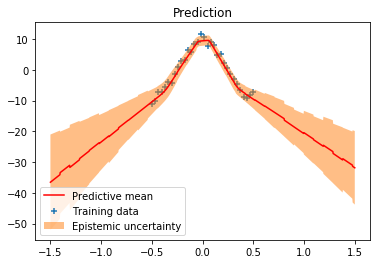

In [6]:
# Plotting predicted values and interval with the training data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend();

# SOME OTHER PYTORCH IMPLEMENTATION

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

In [9]:
%matplotlib inline

In [10]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [11]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

In [12]:
net = NN(28*28, 1024, 10)

In [13]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [14]:
log_softmax = nn.LogSoftmax(dim=1)

In [15]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [16]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [17]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [18]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  2096.204121759454
Epoch  1  Loss  371.5786638194561
Epoch  2  Loss  157.79430113436382
Epoch  3  Loss  111.39913820870717
Epoch  4  Loss  97.4124837875684


In [19]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict


TypeError: eq() received an invalid combination of arguments - got (numpy.ndarray), but expected one of:
 * (Tensor other)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m)
 * (Number other)
      didn't match because some of the arguments have invalid types: ([31;1mnumpy.ndarray[0m)


In [ ]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [ ]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

In [ ]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images 
    

In [ ]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))


In [ ]:
# preparing for evaluation

dataiter = iter(test_loader)
images, labels = dataiter.next()

In [ ]:
test_batch(images[:100], labels[:100])

In [ ]:
# generate random data

images_random = torch.rand(100,28,28)
labels_random = torch.randint(0,10, (100,))

In [ ]:
test_batch(images_random, labels_random)

In [ ]:
class data_loader(Dataset):
	def __init__(self, root):
		Images, Y = [], []
		folders = os.listdir(root)
		folders = folders[1:]

		for folder in folders:
            
			folder_path = os.path.join(root, folder)
			print(folder_path)
            
            
            
			for ims in os.listdir(folder_path):

				img_path = os.path.join(folder_path, ims)
				Images.append(np.array(imread(img_path)))
				Y.append(ord(folder) - 65)  # Folders are A-J so labels will be 0-9
				
		data = [(x, y) for x, y in zip(Images, Y)]
		self.data = data

	def __len__(self):
		return len(self.data)

	def __getitem__(self, index):
		img = self.data[index][0]

		# 8 bit images. Scale between 0, 1
		img = img.reshape(1, 28, 28) / 255

		# Input for Conv2D should be Channels x Height x Width
		img_tensor = transforms.ToTensor()(img).view(1, 28, 28).float()
		label = self.data[index][1]
		return (img_tensor, label)

In [ ]:
# NOT Mnist data

test_dataset_notmnist = data_loader('not-mnist')
test_loader_notmnist = DataLoader(test_dataset_notmnist, batch_size=128, shuffle=True)

In [ ]:
# Prediction when network can decide not to predict

print('Prediction on not-MNIST when network can refuse')
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader_notmnist):
    images, labels = data
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)

In [ ]:
dataiter_notmnist = iter(test_loader_notmnist)
images_notmnist, labels_notmnist = dataiter_notmnist.next()

In [ ]:
test_batch(images_notmnist[:100], labels_notmnist[:100])